In [1]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [9]:
def simulation_exp(model_file):
    model = biolqm.load(model_file)
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1 RB1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1 RB1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0 RB1%1")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1 RB1%1")
    rb1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1 RB1%0")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0 RB1%1")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1 RB1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0 RB1%1")
    flt3_rb1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1 RB1%0")
    npm1_rb1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0 RB1%0")
    dnmt3a_rb1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1 RB1%0") 
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0 RB1%1")
    npm1_dnmt3a_rb1 = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0 RB1%0")
    flt3_dnmt3a_rb1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1 RB1%0")
    flt3_npm1_rb1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0 RB1%0")
    flt3_npm1_dnmt3a_rb1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0 RB1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,rb1, npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_rb1, npm1_rb1, dnmt3a_rb1, flt3_npm1_dnmt3a, npm1_dnmt3a_rb1, flt3_dnmt3a_rb1, flt3_npm1_rb1, flt3_npm1_dnmt3a_rb1]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","rb1","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_rb1", "npm1_rb1", "dnmt3a_rb1", "flt3_npm1_dnmt3a", "npm1_dnmt3a_rb1", "flt3_dnmt3a_rb1", "flt3_npm1_rb1", "flt3_npm1_dnmt3a_rb1"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['RB1'] - results['BCL2']
    results['DIFFERENTIATION'] = results['RB1'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results


In [11]:
#simulation_results_palma_exp = simulation_exp('Palma2021_nophe.sbml')
simulation_results_or_exp = simulation_exp('merged_or.sbml')
simulation_results_inhibitor_wins_exp = simulation_exp('merged_inhibitor_wins.sbml')
simulation_results_and_exp = simulation_exp('merged_and.sbml')

In [12]:
# Data file path
tsv_file_path_genes = '../Data/TCGA/SupplementalTable06.tsv'
tsv_file_path_clinical = '../Data/TCGA/nationwidechildrens.org_clinical_patient_laml.txt'

# Mutation data
df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])

# clinical data 
df_clinical = pd.read_csv(tsv_file_path_clinical, sep='\t', usecols=['bcr_patient_barcode', 
                                                            'blast_count',
                                                            'percent_blasts_peripheral_blood'])

# Function to determine mutation combination
def determine_combination(row):
    genes = row['gene_name']
    has_flt3 = 'FLT3' in genes
    has_npm1 = 'NPM1' in genes
    has_dnmt3a = 'DNMT3A' in genes
    has_rb1 = 'RB1' in genes

    if has_flt3 and has_npm1 and has_dnmt3a and has_rb1:
        return "flt3_npm1_dnmt3a_rb1"
    elif has_flt3 and has_dnmt3a and has_rb1:
        return "flt3_dnmt3a_rb1"
    elif has_flt3 and has_npm1 and has_rb1:
        return "flt3_npm1_rb1"
    elif has_dnmt3a and has_npm1 and has_rb1:
        return "npm1_dnmt3a_rb1"
    elif has_flt3 and has_npm1 and has_dnmt3a:
        return "flt3_npm1_dnmt3a"
    elif has_flt3 and has_dnmt3a:
        return "flt3_dnmt3a"
    elif has_flt3 and has_npm1:
        return "flt3_npm1"
    elif has_npm1 and has_dnmt3a:
        return "npm1_dnmt3a"
    elif has_flt3 and has_rb1:
        return "flt3_rb1"
    elif has_npm1 and has_rb1:
        return "npm1_rb1" 
    elif has_dnmt3a and has_rb1:
        return "dnmt3a_rb1"    
    elif has_flt3:
        return "flt3"
    elif has_npm1:
        return "npm1"
    elif has_dnmt3a:
        return "dnmt3a"
    elif has_rb1:
        return "rb1"
    else:
        return "wt"

# Group by TCGA_id and apply the combination function
grouped = df_genes.groupby('TCGA_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(df_clinical, grouped[['TCGA_id', 'mutation']], left_on='bcr_patient_barcode', right_on='TCGA_id')
clinical_result = clinical_result[['TCGA_id', 'mutation', 
                   'blast_count',
                   'percent_blasts_peripheral_blood']]

print(clinical_result)

          TCGA_id     mutation blast_count percent_blasts_peripheral_blood
0    TCGA-AB-2802  npm1_dnmt3a          52                              88
1    TCGA-AB-2803           wt           0                              44
2    TCGA-AB-2804           wt           6                              82
3    TCGA-AB-2805           wt          56                              67
4    TCGA-AB-2806           wt          81                              90
..            ...          ...         ...                             ...
192  TCGA-AB-3007         flt3           7                              90
193  TCGA-AB-3008           wt          90                              71
194  TCGA-AB-3009           wt          63                              51
195  TCGA-AB-3011         npm1          83                              91
196  TCGA-AB-3012           wt          29                              42

[197 rows x 4 columns]


In [13]:
# convert to numeric
clinical_result['blast_count'] = pd.to_numeric(clinical_result['blast_count'])
clinical_result['percent_blasts_peripheral_blood'] = pd.to_numeric(clinical_result['percent_blasts_peripheral_blood'])

# aggregate the mean PB of each mutation profile
clinical_aggr = clinical_result.pivot_table(
    index='mutation', 
    values=['blast_count','percent_blasts_peripheral_blood'],
    aggfunc='mean'
)
clinical_aggr.columns = ['BM_BLAST', 'PB_BLAST']
clinical_aggr.to_csv('clinical_exp.csv')
clinical_aggr

,BM_BLAST,PB_BLAST
mutation,,
dnmt3a,33.421053,63.473684
flt3,44.681818,72.090909
flt3_dnmt3a,48.000000,73.600000
flt3_npm1,46.166667,73.750000
flt3_npm1_dnmt3a,44.176471,76.882353
npm1,55.923077,78.307692
npm1_dnmt3a,31.636364,68.909091
npm1_rb1,25.000000,53.000000
rb1,0.000000,0.000000


In [16]:
def clinical_plot(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    clinicals = ['PB_BLAST', 'BM_BLAST']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, clinical in enumerate(clinicals):
        ax = axes[i]
        # Extract network scores and clinical outcome values
        y = clinical_results.loc['NETWORK', :]
        x = clinical_results.loc[clinical, :]

        # remove zeros
        zeros = np.logical_or(np.isnan(x), np.isnan(y))
        
        # Calculate Pearson Correlation and p-value
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        zeros = np.logical_or(x == 0, y == 0)
        to_remove = np.logical_or(nas, zeros)
        
        x = x[~to_remove]
        y = y[~to_remove]

        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{clinical} vs Network score')
        ax.set_ylabel('Network score')
        ax.set_xlabel('%' + clinical)
    
            # Annotate each data point
        for j in range(len(x)):
            label = y.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
        
        # Annotate Pearson Correlation and p-value
        ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()
#clinical_plot(simulation_results_palma_exp, 'clinical_exp.csv')

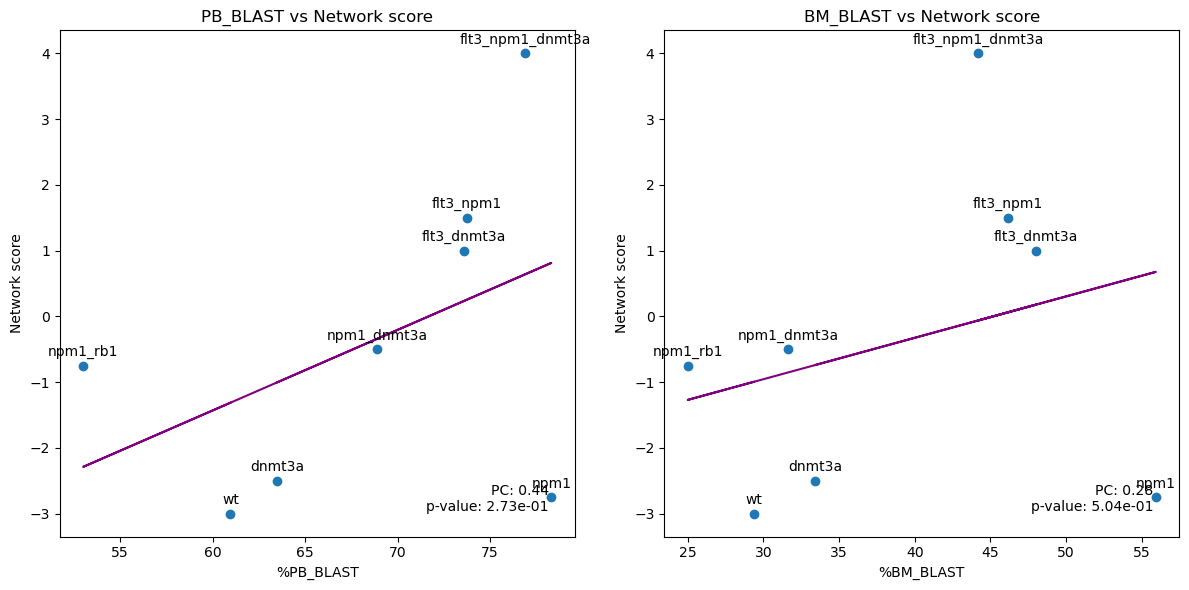

In [17]:
clinical_plot(simulation_results_or_exp, 'clinical_exp.csv')

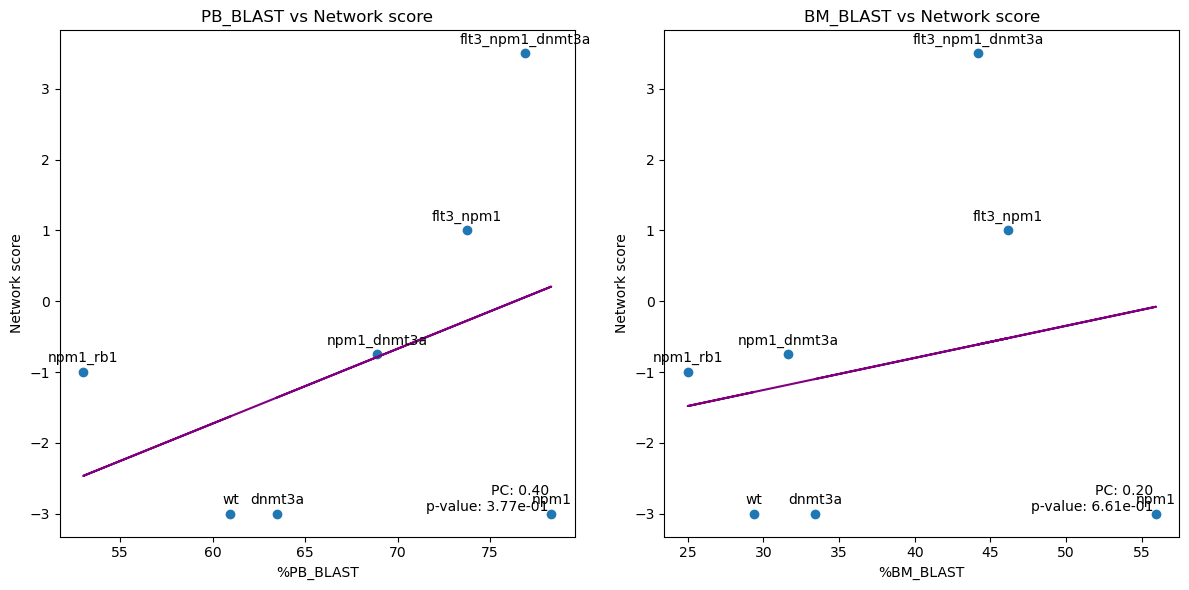

In [18]:
clinical_plot(simulation_results_inhibitor_wins_exp, 'clinical_exp.csv')

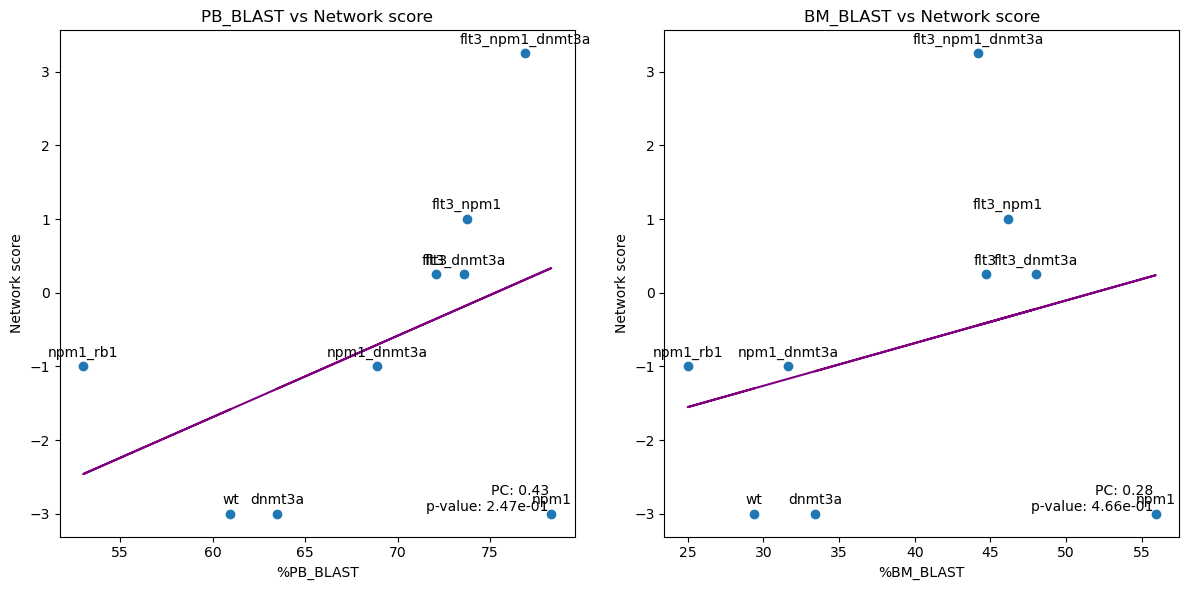

In [19]:
clinical_plot(simulation_results_and_exp, 'clinical_exp.csv')

In [ ]:
def clinical_pc(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    clinicals = ['PB_BLAST', 'BM_BLAST']
    
    clinical_pc_results = pd.DataFrame()
    
    for clinical in clinicals:
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        clinical_pc_results.loc[clinical, 'pc'], clinical_pc_results.loc[clinical, 'p_value'] = pearsonr(x[~nas], y[~nas])
    return clinical_pc_results

clinical_pc_or_exp = clinical_pc(simulation_results_or_exp, 'clinical_exp.csv')